In [205]:
# Global setup
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import control
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
linkMass = 1.0
motorMass = 0.5
springK = 50.0

In [219]:
# want to compute the equations of motions for an SEA system.
def singleSEA():
    
    d = dict()
    d_link = dict()
    d_sea = dict()
    
    # link Model
    # x = [q,q_dot]
    # x = Ax + B tau
    A_link = 1.0*np.array([[0,1],[0,0]])
    B_link = 1.0*np.array([0, 1.0/linkMass])
    
    d_link['A'] = A_link
    d_link['B'] = B_link
    d_link['C'] = np.eye(2)
    d_link['D'] = np.zeros(2)
    
    # SEA model. Locked output assumption with x = [tau, tau_dot]
    # here tau = K(theta - q)
    # know B_motor * theta_ddot + K(theta - q) = tau_m
    # locked output assumption tells us that tau_dot = K theta_dot, tau_ddot = K theta_ddot
    # so then B_motor/springK * tau_ddot + tau = tau_m
    
    M_tau = motorMass/springK
    A_tau = 1.0*np.array([[0,1],[-1.0/M_tau,0]])
    B_tau = 1.0*np.array([0, 1.0/M_tau])
    
    d_sea['A'] = A_tau
    d_sea['B'] = B_tau
    d_sea['C'] = np.eye(2)
    d_sea['D'] = np.zeros(2)
    
    d['link'] = d_link
    d['sea'] = d_sea
    
    # now compute the complete equations
    # linkMass * qddot = K(theta - q)
    # motorMass * thetaddot = -K(theta - q) + tau_m
    H = np.diag([linkMass, motorMass])
    
#     print "C", C
    
    K = springK*np.array([-1,1,0,0])
    KStacked = np.vstack((K,-K))
#     print "KStacked", KStacked
    
    ALower = np.dot(np.linalg.inv(H),KStacked)
    AUpper = np.hstack((np.zeros((2,2)), np.eye(2)))
#     print "AUpper", AUpper
#     print "np.shape(ALowerLeft)", np.shape(ALower)
    
    A_total = np.vstack((AUpper, ALower))
    B_total = np.array([0,0,0,1/motorMass])
    
    d_total = {}
    d_total['A'] = A_total
    d_total['B'] = B_total
    d_total['C'] = np.eye(4,4)
    d_total['D'] = np.zeros(4)
    d['total'] = d_total
    
    return d

def createStateSpaceWithCopy(A,B,C,D):
    
    array = (A,B,C,D)
    m = []
    for i in xrange(0,4):
        matrix = np.asmatrix(np.copy(np.array(array[i])))
#         print type(matrix)
        m.append(matrix)
    
    sys = control.StateSpace(m[0], m[1], m[2], m[3])
#     print type(sys.A)
    return sys
 

In [220]:
d = singleSEA()
d_sea = d['sea']
d_link = d['link']
A = d_link['A']
B = np.reshape(d_link['B'], (2,1))
C = d_link['C']
D = np.reshape(d_link['D'],(2,1))
B = np.reshape(B,(2,1))

# print A
# print B
# print C
# print D
linkSys = control.StateSpace(A,B,C,D)


print d['total']['A']
print d['total']['B']

[[   0.    0.    1.    0.]
 [   0.    0.    0.    1.]
 [ -50.   50.    0.    0.]
 [ 100. -100.    0.    0.]]
[ 0.  0.  0.  2.]


[[10.          4.58257569]]
<class 'numpy.matrixlib.defmatrix.matrix'>
(1, 100)
lqr gain matrix is [[10.          4.58257569]]


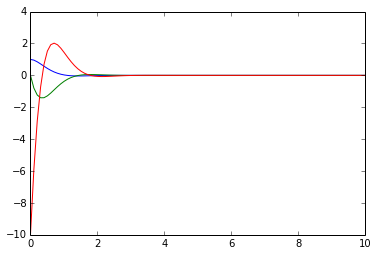

In [226]:
# linkSystem
Q = np.diag((100,1))
R = 1.0
K = control.lqr(linkSys, Q, R)[0]
print K

# create controller system
lqrControllerLink = control.StateSpace(1,0*K,0,K)
lqrControllerLink.dt = 0

print type(lqrControllerLink.A)

# feedback the two systems
linkFeedback = control.feedback(linkSys, sys2=lqrControllerLink, sign=-1)
linkFeedback.dt = 0

# print linkSys.inputs
# print linkSys.states
# print linkFeedback.inputs
# print linkFeedback.outputs
# print linkFeedback.states

# simulate this feedback
X0 = np.array([1,0,0]) # initial condition
T = np.linspace(0,10,100)
T, yout, xout = control.forced_response(linkFeedback, T, X0=X0)

tau_d = np.dot(-K,xout[0:2,:])
print np.shape(tau_d)

# plot the output
plt.plot(T,xout[0,:], label='q')
plt.plot(T,xout[1,:], label='qdot')
plt.plot(T,tau_d.T, label='tau_d')
# plt.legend()

print "lqr gain matrix is", K

(2, 100)
[[   0.    1.]
 [-100.    0.]]
[[   0.]
 [ 100.]]
lqr gain matrix [[ 1.23606798  0.47404785]]
[[ 1.23606798  0.47404785]]
[[ 1.23606798  0.47404785]]


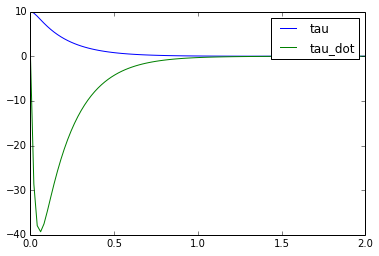

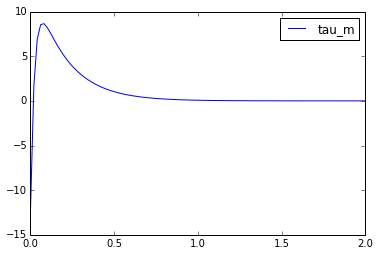

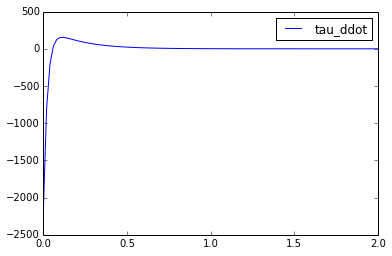

In [227]:
# create the SEA sys
d_sea = d['sea']
A = d_sea['A']
B = np.reshape(d_sea['B'], (2,1))
C = d_sea['C']
D = np.reshape(d_sea['D'],(2,1))
SEAsys = control.StateSpace(A,B,C,D,0)

# get an LQR controller
Q = np.diag((20,1))
R = 5.0

KSEA = control.lqr(SEAsys, Q, R)[0]
lqrControllerSEA = control.StateSpace(1,0*KSEA,0,KSEA)
lqrControllerSEA.dt = 0

seaFeedback = control.feedback(SEAsys, sys2=lqrControllerSEA, sign=-1)
seaFeedback.dt = 0
# simulate this feedback
X0 = [10,0] # initial condition, note extra 0 due to "state" of controller
X0_controller = [0]*lqrControllerSEA.states
X0_complete  = X0 + X0_controller
T = np.linspace(0,2,100)
T, yout, xout = control.forced_response(seaFeedback, T, X0=X0_complete)


# plot the output
plt.figure()
plt.plot(T,xout[0,:], label='tau')
plt.plot(T,xout[1,:], label='tau_dot')
plt.legend()

plt.figure()
tau_m = -np.dot(KSEA,xout[0:2,:])
plt.plot(T,tau_m.T, label='tau_m')
plt.legend()


xdot = np.dot(A,xout[0:2,:]) + np.dot(B,tau_m)
plt.figure()
plt.plot(T,xdot[1,:], label='tau_ddot')
plt.legend()
print np.shape(xdot)

print A
print B
print "lqr gain matrix", KSEA

print lqrControllerSEA.D
print KSEA

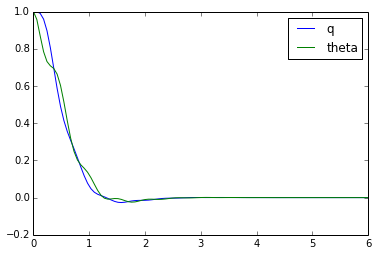

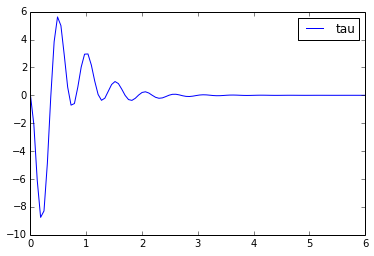

In [228]:
# Simulate the big system with the full lqrController
d_total = d['total']
A = d_total['A']
B = np.reshape(d_total['B'], (4,1))
C = d_total['C']
D = np.reshape(d_total['D'], (4,1))

# print np.shape(D)
# print A

sys = control.StateSpace(A,B,C,D)
Q = np.diag((100,100,5,5))
R = 1
K = control.lqr(sys,Q,R)[0]
lqrController = control.StateSpace(1,0*K,[0],K, 0)


feedbackSys = control.feedback(sys, sys2=lqrController, sign=-1)
feedbackSys.dt = 0


X0 = [1,1,0,0] # initial condition
X0_controller = [0]*lqrController.states
X0_complete  = X0 + X0_controller
T = np.linspace(0,6,100)
T, yout, xout = control.forced_response(feedbackSys, T, X0=X0_complete)

plt.figure()
plt.plot(T,xout[0,:], label='q')
plt.plot(T,xout[1,:], label='theta')
plt.legend()

plt.figure()
plt.plot(T,springK*(xout[1,:] - xout[0,:]), label='tau')
plt.legend()

D_tau_d [[-10.          0.         -4.58257569  0.        ]]
D_tau [[-50.  50.   0.   0.]]
[[  0.   0.   0.  50.]]
D [[-10.           0.          -4.58257569   0.        ]
 [-50.          50.           0.           0.        ]
 [  0.           0.           0.          50.        ]]
y is [[-1.  1.  0.]
 [ 0.  0.  1.]]
D_2 is [[ 1.23606798 -1.23606798 -0.47404785]]
yout.shape (4, 100)
(1, 100)


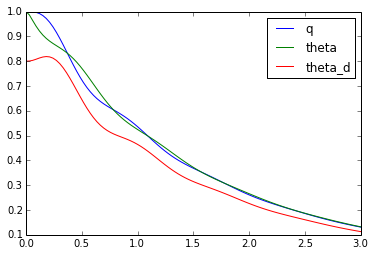

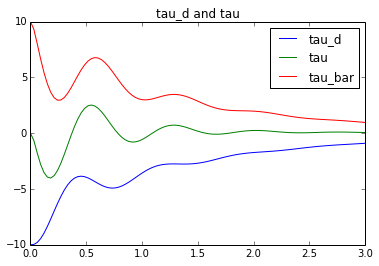

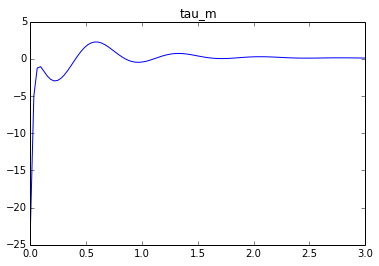

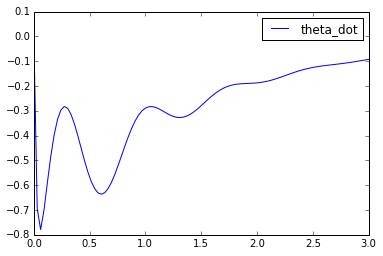

In [229]:
# simulate the full system with the cascaded controller

# outerController
# input: x
# output: [tau_d, tau, K theta_dot]

n = 1 # number of links
D_tau_d = np.zeros((n,4*n))
D_tau_d[0:n,0:n] = -lqrControllerLink.D[:,0:n] # q terms
D_tau_d[0:n,2*n:3*n] = -lqrControllerLink.D[:,n:] # qdot terms
print "D_tau_d", D_tau_d

# compute the joint torques
D_tau = np.zeros((n,4*n))

for i in xrange(0,n):
    D_tau[i,i] = -springK
    D_tau[i,i+n] = springK

    
print "D_tau", D_tau

D_KTheta = np.zeros((n,4*n))
for i in xrange(0,n):
    D_KTheta[i,3*n+i] = springK

print D_KTheta

D = np.vstack((D_tau_d,D_tau,D_KTheta))
print "D", D

m = 1 # num fictitious states
A = np.ones((m,m))
B = np.zeros((m,np.shape(D)[1]))
C = np.zeros((np.shape(D)[0],m))


outerController = control.StateSpace(A,B,C,D)


# innerController
# input: outerController.output
# output: tau_m, which is the motor torque command

# innerController will be connected in series with the outerController

# again will only have D

# ultimately D_inner should be n x 3n
D_1 = np.zeros((n,3*n))
D_1[:,0:n] = np.eye(n)

# print "np.shape(D_1)", np.shape(D_1)

y = 1.0*np.zeros((2*n,3*n))
y[0:n,0:n] = -np.eye(n) # tau_d
y[0:n,n:2*n] = np.eye(n) # tau
y[n:,2*n:] = np.eye(n) # K theta_dot = tau_dot

print "y is", y

 

# print "y", y
D_2 = np.dot(-lqrControllerSEA.D, y)
print "D_2 is", D_2

D_inner = D_1 + D_2;

A = np.ones((m,m))
B = np.zeros((m,np.shape(D_inner)[1]))
C = np.zeros((np.shape(D_inner)[0],m))

innerController = createStateSpaceWithCopy(A,B,C,D_inner)


# to make the controller just need to series connect outerController -> innerController
controllerSys = control.series(outerController, innerController)

# now want to feedback the controller and the plant
feedbackDecoupledSys = control.feedback(sys, sys2=controllerSys, sign=1)


X0 = [1,1,0,0] # initial condition
X0_controller = [0]*controllerSys.states
X0_complete  = X0 + X0_controller
T = np.linspace(0,3,100)
T, yout, xout = control.forced_response(feedbackDecoupledSys, T, X0=X0_complete)

print "yout.shape", yout.shape

tau_d = np.dot(D_tau_d, xout[0:4,:])
theta_d = xout[0,:] + tau_d/springK



plt.plot(T,xout[0,:], label='q')
plt.plot(T,xout[1,:], label='theta')
plt.plot(T,theta_d.T, label='theta_d')
# plt.plot(T,xout[3,:], label='theta_dot')
plt.legend()


print np.shape(tau_d)
plt.figure()
plt.plot(T, tau_d.T, label='tau_d')

tau = np.dot(D_tau, xout[0:4,:])
plt.plot(T,tau.T, label='tau')


tau_bar = tau - tau_d
plt.plot(T,tau_bar.T, label='tau_bar')

plt.title('tau_d and tau')
plt.legend()

tau_m = np.dot(controllerSys.D, xout[0:4,:])
plt.figure()
plt.plot(T,tau_m.T)
plt.title('tau_m')

plt.figure()
# KthetaDot = springK*x[3,:]
plt.plot(T,xout[3,:], label='theta_dot')
plt.legend()



In [225]:
a = np.array([[0,0]])
print a
print a.T

[[0 0]]
[[0]
 [0]]
